# RTL-SDR Ultrasound Test
Copyright (C) 2018 William Meng

This file is part of rtlsdr_ultrasound

rtlsdr_ultrasound is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

rtlsdr_ultrasound is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with rtlsdr_ultrasound.  If not, see <http://www.gnu.org/licenses/>.

-------
William Meng K9TTL  
Aug 13, 2018

In this notebook, I will demonstrate how to:
* use pyrtlsdr to receive IQ samples of ultrasound data
* extract the envelope of the ultrasound signal
* approximately reconstruct the original ultrasound signal (albeit with different initial phase)
* slice the scanlines according to a trigger threshold and holdoff time
* plot a 2D image

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rtlsdr import *
from scipy.signal import resample
from scipy.signal import hilbert
import time
from datetime import datetime
%matplotlib inline

## Configure settings for RTL-SDR

In [25]:
sdr = RtlSdr()

# configure device
sdr.set_direct_sampling(2) # directly sample Q channel
sdr.center_freq = 8e6
sdr.sample_rate = 2.4e6
sdr.gain = 'auto'

center_freq = sdr.center_freq
sample_rate = sdr.sample_rate
print("center freq = {} Hz".format(center_freq))
print("sample rate = {} Hz".format(sample_rate))
print("gain = {}".format(sdr.gain))

center freq = 8000000 Hz
sample rate = 2400000.0 Hz
gain = 0.0


## Acquire data and save to file

In [3]:
# read samples
samples = sdr.read_samples(256*512)
sdr.close()

# save samples to disk with timestamp
timestamp = datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d_%H:%M:%S')
np.save("rtlsdr_ultrasound_test_{}".format(timestamp), samples)

## Load data from file and plot

[-0.00392157+0.00392157j  0.00392157+0.00392157j -0.00392157-0.00392157j
 ...,  0.00392157+0.00392157j  0.00392157+0.00392157j
 -0.00392157+0.00392157j]
Found 131072 samples


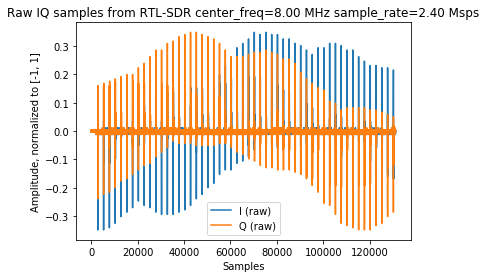

In [22]:
samples = np.load("rtlsdr_ultrasound_test_2018-08-13_13:16:29.npy")
print(samples)
print("Found {} samples".format(len(samples)))
I_raw = np.real(samples)
Q_raw = np.imag(samples)
plt.plot(I_raw, label="I (raw)")
plt.plot(Q_raw, label="Q (raw)")
plt.title("Raw IQ samples from RTL-SDR center_freq=%.2f MHz sample_rate=%.2f Msps" % (center_freq/1e6, sample_rate/1e6))
plt.xlabel("Samples")
plt.ylabel("Amplitude, normalized to [-1, 1]")
plt.legend()
plt.show()

## Process signal
### Upsample and generate time base

In [23]:
upsampling_factor = 10
resampled = resample(samples, len(samples) * upsampling_factor)
fs = sample_rate * upsampling_factor
Ts = 1e6/fs # time per sample after resampling, in microseconds
print("Resampled at:")
print("fs = %.2f Msps" % (fs/1e6))
print("Ts = {} microseconds".format(Ts))
t = np.array([ x * Ts for x in range(len(resampled))]) # time base, in microseconds

Resampled at:
fs = 24.00 Msps
Ts = 0.041666666666666664 microseconds


### Plot envelope

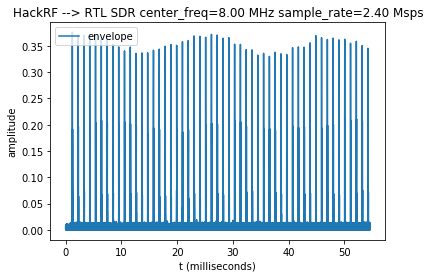

In [33]:
envelope = np.abs(resampled)
t_ms = t/1000
plt.plot(t_ms, envelope, label="envelope")
plt.xlabel('t (milliseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

*[Let's enhance](https://www.youtube.com/watch?v=LhF_56SxrGk) the image...*

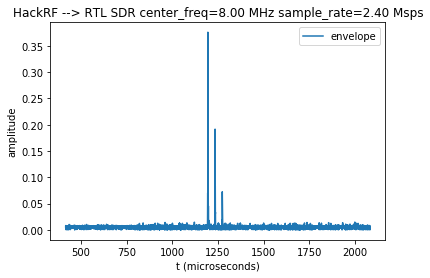

In [32]:
start = 10000
end = 50000
zoomed_envelope = envelope[start:end]
zoomed_t = t[start:end]
plt.plot(zoomed_t, zoomed_envelope, label="envelope")
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

*What's that over there? Zoom and enhance.*

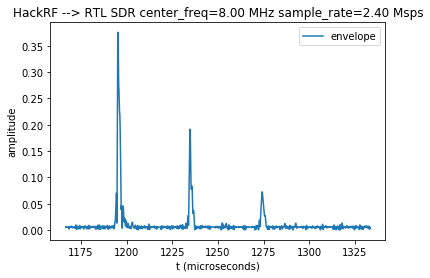

In [51]:
start1 = 28000
end1 = 32000
megazoomed_envelope = envelope[start1:end1]
megazoomed_t = t[start1:end1]
plt.plot(megazoomed_t, megazoomed_envelope, label="envelope")
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

~~Look over there, it's a corneal reflection!~~

We have an envelope signal that corresponds nicely to the original data from kelu124:  
![example data from un0rick](https://raw.githubusercontent.com/kelu124/un0rick/master/images/20180403/p_A-130us-0-VGA%400x22-spimode1-64msps.jpg)

## Approximate reconstruction of original ultrasound signal

~~Extract vector a6 and use it to reconstruct the face...~~

Just kidding, you can't just magically reconstruct a real signal... you also need the imaginary part!

We can construct an RF signal from IQ samples by modulating a cosine and sine at the carrier frequency by I and Q, respectively, then subtracting the results.

$ r(t) = I(t) \cos(2\pi f_c t) - Q(t) \sin(2\pi f_c t)$, 
where $f_c$ is the carrier frequency

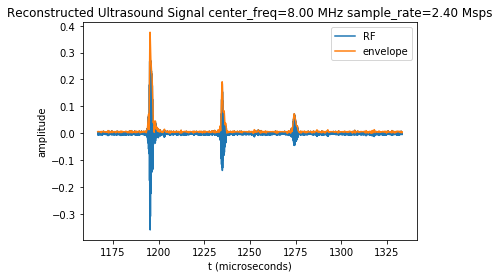

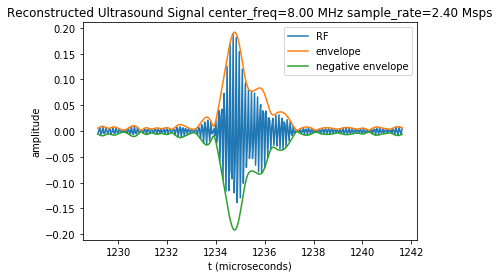

In [62]:
megazoomed_data = resampled[start1:end1]
I = np.real(megazoomed_data) # In-phase modulating signal
Q = np.imag(megazoomed_data) # Quadrature-phase modulating signal
LO_cos = np.cos(2.0*np.pi*center_freq*megazoomed_t) # Local Oscillator, cos
LO_sin = np.sin(2.0*np.pi*center_freq*megazoomed_t) # Local Oscillator, sin
RF = I*LO_cos - Q*LO_sin # reconstructed RF signal

plt.plot(megazoomed_t, RF, label="RF")
plt.plot(megazoomed_t, megazoomed_envelope, label="envelope")
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("Reconstructed Ultrasound Signal center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

# zoom in on RF signal
start2 = 1500
end2 = 1800
zoomed_RF = RF[start2:end2]
plt.plot(megazoomed_t[start2:end2], zoomed_RF, label="RF")
plt.plot(megazoomed_t[start2:end2], megazoomed_envelope[start2:end2], label="envelope")
plt.plot(megazoomed_t[start2:end2], -megazoomed_envelope[start2:end2], label="negative envelope")
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("Reconstructed Ultrasound Signal center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

There's no guarantee that LO_cos and LO_sin have an intial phase matching the ultrasound signal's initial phase.
Also, there's no guarantee that the LO frequency is exactly equal to ultrasound signal's frequency
(which should equal the resonant frequency of the piezo transducer).
The IQ samples only describe how the RF signal is modulated, and convey no information whatsoever about the carrier signal.

However, this is still a good way to approximately visualize the relation of the envelope signal to the original ultrasound signal.

## Construct image

To construct a 2D ultrasound image, we need to slice the 1D ultrasound signal into individual scan lines.
This can be done by setting a an appropriate threhold amplitude for identifying a trigger pulse,
and the minimum time for a scan line so as to prevent slicing the signal in the middle of a scan line.
This is exactly analogous to the trigger level and trigger holdoff settings on an oscilloscope.

### Set trigger level and holdoff

max(envelope) = 0.37580465651100414
Trigger level = 0.30064372520880334


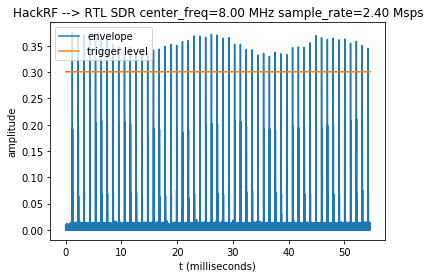

In [67]:
max_envelope = np.max(envelope)
print("max(envelope) = {}".format(max_envelope))
trigger_level = 0.8 * max_envelope
print("Trigger level = {}".format(trigger_level))

plt.plot(t_ms, envelope, label="envelope")
plt.plot(t_ms, [trigger_level] * len(t_ms), label="trigger level")
plt.xlabel('t (milliseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

In [71]:
trigger_holdoff_us = 130 # trigger holdoff time in microseconds
trigger_holdoff = int(trigger_holdoff_us / Ts) # trigger holdoff in # of samples
print("Trigger holdoff = {} microseconds = {} samples".format(trigger_holdoff_us, trigger_holdoff))

Trigger holdoff = 130 microseconds = 3120 samples


### Slice into scan lines
Now let's iteratively identify the slicing points, and plot the first few.

Slicing at indices [28683, 53643, 78603, 103563, 128523, 153483, 178443, 203404, 228364, 253324, 278284, 303245, 328205, 353165, 378125, 403085, 428046, 453005, 477966, 502926, 527886, 552845, 577805, 602765, 627725, 652685, 677645, 702606, 727566, 752526, 777486, 802446, 827407, 852367, 877327, 902288, 927248, 952209, 977168, 1002128, 1027088, 1052048, 1077008, 1101968, 1126928, 1151888, 1176848, 1201808, 1226768, 1251728, 1276688, 1301649]
Triggered 52 times


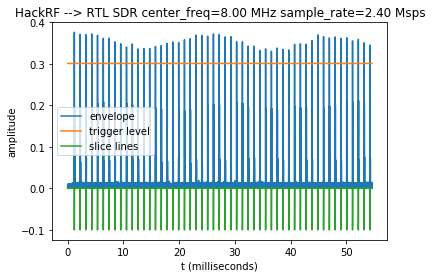

CPU times: user 9.21 s, sys: 491 ms, total: 9.7 s
Wall time: 10.2 s


In [82]:
%%time
prev_trigger = -trigger_holdoff # allow first trigger to be at 0th sample
slice_indices = list()
for i in range(len(envelope)):
    if i >= prev_trigger + trigger_holdoff:
        if envelope[i] > trigger_level:
            slice_indices.append(i)
            prev_trigger = i

print("Slicing at indices {}".format(slice_indices))
print("Triggered {} times".format(len(slice_indices)))

# Visualize where the slicing happens
slice_lines = np.zeros(len(envelope))
"""
# this is extremely slow, because the numpy array has to be copied in memory for each substitution
for i in range(len(slice_lines)):
    if i in slice_indices:
        slice_lines[i] = -0.1
"""
# faster method:
slice_lines[slice_indices] = -0.1

plt.plot(t_ms, envelope, label="envelope")
plt.plot(t_ms, [trigger_level] * len(t_ms), label="trigger level")
plt.plot(t_ms, slice_lines, label="slice lines")
plt.xlabel('t (milliseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
          (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

Intervals between each trigger are [24960 24960 24960 24960 24960 24960 24961 24960 24960 24960 24961 24960
 24960 24960 24960 24961 24959 24961 24960 24960 24959 24960 24960 24960
 24960 24960 24961 24960 24960 24960 24960 24961 24960 24960 24961 24960
 24961 24959 24960 24960 24960 24960 24960 24960 24960 24960 24960 24960
 24960 24960 24961]
Choosing the minimum, 24959, as the length of each scan line
Not enough samples left for a complete scan line!
Created 51 scan lines


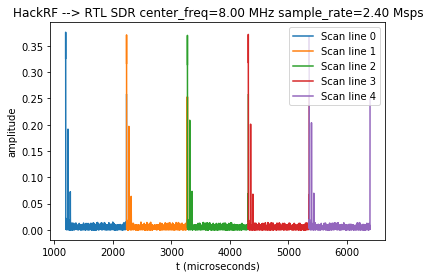

In [97]:
# slice array and vstack
diffs = np.diff(slice_indices)
min_diff = np.min(diffs)
print("Intervals between each trigger are {}".format(diffs))
print("Choosing the minimum, {}, as the length of each scan line".format(min_diff))

scan_lines = list()
for index in slice_indices:
    if len(envelope) < index + min_diff:
        print("Not enough samples left for a complete scan line!")
        continue
    scan_line = envelope[index:index+min_diff]
    scan_lines.append(scan_line)

print("Created {} scan lines".format(len(scan_lines)))

# Plot first 5 scan lines
for i in range(5):
    index = slice_indices[i]
    plt.plot(t[index:index+min_diff], scan_lines[i], label="Scan line {}".format(i))
 
plt.xlabel('t (microseconds)')
plt.ylabel('amplitude')
plt.title("HackRF --> RTL SDR center_freq=%.2f MHz sample_rate=%.2f Msps" %
      (center_freq/1.0e6, sample_rate/1.0e6))
plt.legend()
plt.show()

### Stack scan lines into image
Use numpy.vstack(), then (optionally) crop the 2D array to get rid of some blank space.

Image dimensions: (51, 24959)


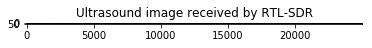

In [121]:
image = np.vstack(tuple(scan_lines))
print("Image dimensions: {}".format(image.shape))
plt.imshow(image, cmap='gray')
plt.title("Ultrasound image received by RTL-SDR")
plt.show()

### Crop and repeat image for easier viewing

Cropped imsage dimensions: (51, 3000)


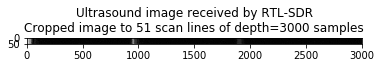

Repeated image dimensions: (510, 3000)


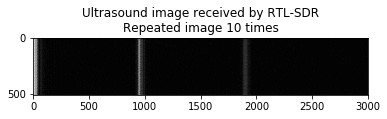

In [123]:
max_depth = 3000
image_cropped = image[:,:max_depth]
print("Cropped image dimensions: {}".format(image_cropped.shape))
plt.imshow(image_cropped, cmap='gray')
plt.title("Ultrasound image received by RTL-SDR\nCropped image to {} scan lines of depth={} samples".format(*image_cropped.shape))
plt.show()

n = 10 # number of times to repeat image
image_repeated = np.vstack(tuple([image_cropped]*n))
print("Repeated image dimensions: {}".format(image_repeated.shape))
plt.imshow(image_repeated, cmap='gray')
plt.title("Ultrasound image received by RTL-SDR\nRepeated image {} times".format(n))
plt.show()

### View image in polar coordinates

This will be useful for viewing images acquired from a B-mode ultrasound device
where the transducer angle is sweeped mechanically.

In [ ]:
%%time
import polarTransform

polarImage, ptSettings = polarTransform.convertToPolarImage(
    image_repeated, initialRadius=30, finalRadius=100,
    initialAngle=4/3*np.pi, finalAngle=5/3*np.pi)

print("Interpreted image with polar coordinates")

cartesianImage = ptSettings.convertToCartesianImage(polarImage)
print("View polar image in cartesian units")
plt.imshow(cartesianImage, origin='lower')
plt.show()

# this code gets stuck...
# consider using scipy.ndimage.interpolation.geometric_transform()
# or cv2.linearPolar()